[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/AlbertoGCID/Antiviral/blob/main/Antiviralautoencoder.ipynb)

# Código extraído del trabajo de Adriana Anido Alonso
## https://github.com/adrania/COVID19-Drugs-repurposing/blob/main/Mordred_ML.ipynb

In [4]:
%matplotlib inline

import os
path = os.getcwd()
os.chdir(path)
import time
import pyqsar
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

# Descriptors
from pandas import read_csv
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

#Processing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, classification_report
from sklearn.utils import class_weight

# Machine learning
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier, RandomTreesEmbedding
from sklearn.neural_network import MLPClassifier

In [5]:
def GetRdkitFeatures (descriptors, data):
    '''Gives a table of features from a smile. Descriptor's list is given by the user.'''

    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors) # first it creates a calculator object with the descriptors
    #print(calculator.GetDescriptorSummaries()) # if we want to get a calculator summary
    values = [] # creates a list to append each value
    
    for smile in data.smiles:
        mol = Chem.MolFromSmiles(smile) # it creates a rdkit molecule object for each smile data
        if mol is None: continue
        desc = calculator.CalcDescriptors(mol) # generates a tuple with the features for each smile
        values.append(desc) # it accumulates each tuple in a list
        features = pd.DataFrame(values, columns = descriptors) # transform the list into a dataframe
    
    return features

def ProcessData(i):
    '''Replace not float values with NaN.'''
    try: 
        return float(i)
    except:
        return np.nan
    
def GetColumns (data):
    '''Gets those columns with a percentage of cells with NaN values >= 50%.'''
    columns = []
    for col in data:
        percent = data[col].isnull().sum()/data[col].isnull().count()
        if percent >= 0.5:
            columns.append(col)
    return columns

def ML_score (models, X_train, Y_train, X_test, Y_test, seed, classes = ['0','1']):
    '''Fit diferent models, predict and return models' scores'''
    ACC = 0
    AUROC = 0
    precision = 0 
    recall = 0
    f1score = 0
    
    model_name = type(models).__name__ # get model name
    start_time = time.time()
    
    # Train different models using cross validation 
    print('> Training time: %0.2f mins'% ((time.time()-start_time)/60))
        
    models.fit(X_train, Y_train)
    
    # Predict
    y_pred = models.predict(X_test)
    y_probs = models.predict_proba(X_test)[:, 1]
    model_report = classification_report(Y_test, y_pred, target_names=classes, output_dict=True, digits=3)
     
    # Scores
    ACC = accuracy_score(Y_test, y_pred)
    AUROC = roc_auc_score(Y_test, y_probs)
    precision = model_report['weighted avg']['precision']
    recall = model_report['weighted avg']['recall']
    f1score = model_report['weighted avg']['f1-score']
    
    return ACC, AUROC, precision, recall, f1score

In [ ]:

# Load datasets
antiv = read_csv('antivirals_SMILES.csv')
drugs = read_csv('DB_SMILES4prediction.csv')

In [ ]:

# Get RDKIT descriptors from smiles
des_list = [x[0] for x in Descriptors._descList] # get all rdkit posible descriptors

antiv_rdkit = pd.concat([antiv, GetRdkitFeatures(des_list, antiv)], axis=1)
drugs_rdkit = pd.concat([drugs, GetRdkitFeatures(des_list, drugs)], axis=1)

In [ ]:

# Save descriptors 
antiv_rdkit.to_csv('antiv_rdkit.csv', index_label=False)
drugs_rdkit.to_csv('drugs_rdkit.csv', index_label=False)

In [ ]:
# Load feature datasets
antiv_rdkit = read_csv('antiv_rdkit.csv', low_memory=False) #to solve different column types
antiv = antiv_rdkit.copy() # train

drugs_rdkit = read_csv('drugs_rdkit.csv', low_memory=False) #to solve different column types
drugs = drugs_rdkit.copy() # predict

In [ ]:
# Split ids and features
a = antiv.iloc[:,2:]
id_a = antiv.loc[:,:'Class']

d = drugs.iloc[:,3:]
id_d = drugs.loc[:,:'Class']

# Replace different column types with NaN values
a = a.applymap(ProcessData)
d = d.applymap(ProcessData)

# Restore datasets
antiv = pd.concat([id_a, a], axis=1)
drugs = pd.concat([id_d, d], axis=1)

In [ ]:
# First aproximation: any NaN value?
print('Has Antivirals dataset NaN values?', antiv.isnull().values.any()) #true
print('>> Columns with NaN: ', antiv.isnull().any().sum(), ' / ', len(antiv.columns))
print('>> Number of data points with NaN: ', antiv.isnull().any(axis=1).sum(), ' / ', len(antiv))
print('>> Number of rows with all NaN values: ', antiv.loc[:,'MaxEStateIndex':].isnull().all(axis=1).sum())

print('\nHas Drugs dataset NaN values?', drugs.isnull().values.any()) #true
print('>> Columns with NaN: ', drugs.isnull().any().sum(), ' / ', len(drugs.columns))
print('>> Number of data points with NaN: ', drugs.isnull().any(axis=1).sum(), ' / ', len(drugs))
print('>> Number of rows with all NaN values: ', drugs.loc[:,'MaxEStateIndex':].isnull().all(axis=1).sum())

In [ ]:
# Remove 8 rows with all NaN values in drugs dataset
all_NA = [10246,10247,10248,10249,10250,10251,10252,10253] # all nan values from 10246 till 10253
drugs = drugs.drop(all_NA) # remove 8 drugs from the drug dataset

In [ ]:

# Select columns to drop from antivirals dataset
to_drop = GetColumns(antiv)

# Drop the same columns in each dataset
antiv.drop(to_drop, axis=1, inplace=True) #same columns are removed
drugs.drop(to_drop, axis=1, inplace=True) #same columns are removed

In [ ]:
# Second aproximation 
print('Has Antivirals NaN values?', antiv.isnull().values.any()) #false
print('Has Drugs NaN values?', drugs.isnull().values.any()) #true

# Replace any NaN value with 0
antiv = antiv.fillna(0)
drugs = drugs.fillna(0)

print('Has Antivirals NaN values?', antiv.isnull().values.any()) #false
print('Has Drugs NaN values?', drugs.isnull().values.any()) #false

In [ ]:
# Save preprocessed files
antiv.to_csv('antiv_prepro_rdkit.csv', index_label=False)
drugs.to_csv('drugs_prepro_rdkit.csv', index_label=False)

In [7]:

# Load dataset
input_data = read_csv('archivos/antiv_prepro_rdkit.csv')

In [8]:
# Remove smiles from dataset
input_data = input_data.loc[:,'Class':]

In [9]:
# Set categoricals
input_data['Class'] = pd.Categorical(input_data['Class'])

# Train and test dataset, one split 0.8 train, 0.2 test. Random_state=80
x = input_data[input_data.iloc[:,1:].columns] 
y = input_data['Class']

x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.2, random_state=80)

print('Full dataset samples: {}'.format(input_data.shape[0]))
print('Train dataset samples: {}'.format(x_train.shape[0]))
print('Test dataset samples: {}'.format(x_test.shape[0]))

Full dataset samples: 229
Train dataset samples: 183
Test dataset samples: 46


In [13]:
# Standardize data using only train set
sc = StandardScaler().fit(x_train)
sc.get_params();

In [14]:
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

x_train_std.mean(axis=0);
x_train_std.std(axis=0);

In [15]:
# Transform splits from arrays into DataFrames
df_train = pd.DataFrame(x_train_std, columns=list(input_data.iloc[:,1:].columns))
df_train['Class'] = y_train

df_test = pd.DataFrame(x_test_std, columns=list(input_data.iloc[:,1:].columns))
df_test['Class'] = y_test

# HASTA AQUÍ EL CÓDIGO DEL TFG DE ADRIANA
## A partir de aquí, parto de los CSV generados para generar el modelo con autoencoder

In [102]:
print(df_train.shape)
#183 muestras con 209 características
# pero este dataset tiene las etiquetas
# para la seleccion de características me quedo únicamente con las variables sin la etiqueta (que es la última)
df_train_se = df_train.iloc[:,:-1]
print(df_train_se.shape)
df_train_se.head()

(183, 209)
(183, 208)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.039730,0.795004,0.039730,-0.347689,0.109341,0.012647,-0.054600,0.013548,0.116396,0.0,...,2.258318,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0
1,0.243550,0.684399,0.243550,-0.507950,1.475144,-1.037036,-1.086733,-1.035403,-0.776706,0.0,...,-0.442807,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0
2,0.639337,0.296942,0.639337,-0.601503,-0.752071,0.824439,0.930773,0.821683,0.652258,0.0,...,-0.442807,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0
3,0.512692,0.655023,0.512692,-0.683701,-1.193726,1.446045,1.531216,1.447521,1.411394,0.0,...,-0.442807,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0
4,0.123440,0.771337,0.123440,-0.609176,1.024848,-0.999173,-1.165782,-0.997665,-0.598086,0.0,...,-0.442807,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0


In [105]:
print(df_test.shape)
df_test_se = df_test.iloc[:,:-1] 
print(df_test_se.shape)
df_test_se.head()
#46 muestras con 209 características

(46, 209)
(46, 208)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.696203,0.159864,0.696203,0.115840,-1.730217,1.962905,1.808900,1.964641,2.259842,0.0,...,-0.442807,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0
1,-0.280431,0.846388,-0.280431,-0.581039,1.390979,-1.128080,-1.284822,-1.126545,-0.732051,0.0,...,-0.442807,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0
2,0.625427,0.335273,0.625427,-0.190117,-0.619942,0.471647,0.500352,0.472996,0.518292,0.0,...,-0.442807,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0
3,0.106775,0.798175,0.106775,0.114934,-0.293715,0.141554,0.064440,0.142428,0.250361,0.0,...,2.258318,-0.433949,-0.25289,0.0,0.0,-0.227429,0.0,-0.311645,-0.100082,0.0
4,-3.431360,1.321082,-3.431360,3.006597,-0.423819,-0.070274,-0.034134,-0.070138,-0.240845,0.0,...,2.258318,-0.433949,-0.25289,0.0,0.0,3.240869,0.0,-0.311645,-0.100082,0.0


## Creo el Autoencoder

In [106]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers,losses
from random import seed
from matplotlib import pyplot

seed(90) # Fijamos una semilla para que las pruebas sean reproducibles

In [109]:
# la entrada es un vector de (1x209)
def crearencoder(entradas,dimension):
    encoder = tf.keras.Sequential()
    dim = entradas.shape[1] # cogemos el número de características
    encoder.add(tf.keras.layers.InputLayer(dim))
    encoder.add(tf.keras.layers.Dense(dim,activation='relu'))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    encoder.add(tf.keras.layers.Dense(dim//2,activation='relu'))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))    
    encoder.add(tf.keras.layers.Dense(dim//4,activation='relu'))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))  
    encoder.add(tf.keras.layers.Dense(dimension,activation='softmax'))
    encoder.build()
    return encoder

def creardecoder(entradas,dimension):
    dim = entradas.shape[1]
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.layers.InputLayer(dimension))  
    decoder.add(tf.keras.layers.Dense(dim,activation='relu'))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    decoder.add(tf.keras.layers.Dense(dim//4,activation='relu'))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    decoder.add(tf.keras.layers.Dense(dim//2,activation='relu'))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    decoder.add(tf.keras.layers.Dense(dim,activation='linear'))
    decoder.build()
    return decoder

def buildautoencoder(entradas,dimension):
    encoder = crearencoder(entradas,dimension)
    decoder = creardecoder(entradas,dimension)
    autoencoder = tf.keras.Sequential([encoder,decoder])
    autoencoder.build(entradas.shape)
    autoencoder.compile(loss=fn_perdida,optimizer='Adam',metrics="mse")
    return autoencoder,decoder,encoder

def plottrain(historico):
    pyplot.plot(historico.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()
    
def probarmodelo(train,dimension,test,Epochs):
    modelocreado,decoder,encoder = buildautoencoder(entradas,dimension)
    historico = modelocreado.fit(train,train,batch_size=batchs, epochs= Epochs,verbose=False)
    plottrain(historico)
    latente = encoder.predict(test,verbose=False)
    reconstruidos = decoder.predict(latente,verbose=False)
    #ahora tengo que calcular la pérdida entre las entradas y los reconstuidos
    return fn_perdida(test, reconstruidos)

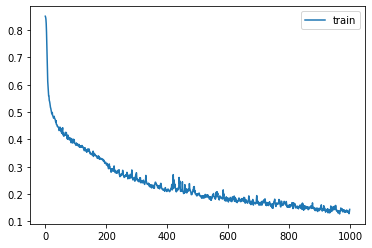

El error con espacio latente 10 y 1000 epochs 30.33 %


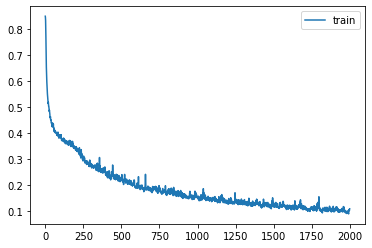

El error con espacio latente 10 y 2000 epochs 29.90 %


In [ ]:
#lo junto todo para probar parámetros
dimension_h = [10,50]
fn_perdida = tf.keras.losses.MeanSquaredError()
Epochs = [1000,2000]
batchs = 30
for i in dimension_h:
    for j in Epochs:
        precisiontest = probarmodelo(df_train_se,i,df_test_se,j).numpy()
        print("El error con espacio latente {} y {} epochs {:.2f} %".format(i,j,precisiontest*100))